In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete73VKF9/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete73VKF9/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
#Let's normalize the image - divide each pixel by 255 to ensure data boundories between [0,1] 
#Aditionally the labels are (1,2,3), subtract -1
def normalize(data,labels):
    data = tf.cast(data,tf.float32)/255
    labels -= 1
    
    return data,labels

@tf.function
def load_image_train(datapoint):
    
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    if(tf.random.uniform(()) > 0.5):
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image,input_mask = normalize(input_image,input_mask)
    
    return input_image,input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)


train_size = info.splits['train'].num_examples
batch_size = 64
train_steps = train_size // batch_size

train = train.cache().shuffle(1000).batch(batch_size).repeat()
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)

test = test.batch(batch_size)

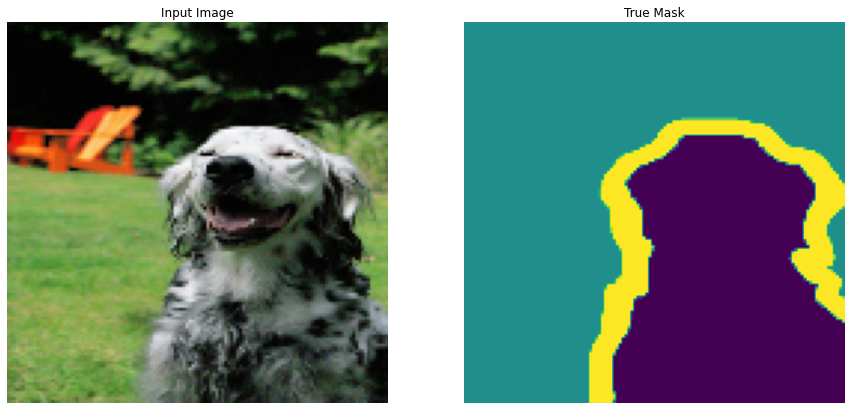

In [5]:
#Function to display the image and tge corresponding mask
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
  
  
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image[0], sample_mask[0]])

## Let's define the U-Net model

[U-Net architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

In [6]:
mobileNet = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),include_top=False)

##According to the summary of the model and Tensorflow documention Ill only use this layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4 - 320
]
layers = [mobileNet.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=mobileNet.input, outputs=layers)
down_stack.trainable = False

x = np.zeros(shape=(1,128,128,3))
assert len(down_stack(x)) == len(layers) ##ensure that we have 5 ouputs each layer in layer names from MobileNet

from functools import partial

conv2Dtransposed = partial(
    tf.keras.layers.Conv2DTranspose,
    filters=32, 
    kernel_size=(3,3),
    strides=(2,2),   
    padding = 'same',
    activation='linear',
    use_bias=False
)



def up_stack_model(filters):
    model = tf.keras.models.Sequential()
    model.add(conv2Dtransposed(filters=filters))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    return model
    
##Every layer needs by its own to be a Sequential model, this why one can iterate over multiple Sequential models 
##instead of iteration over several layers in unique sequential block
##The the next for the see why
up_stack=[
    up_stack_model(512),
    up_stack_model(216),
    up_stack_model(128),
    up_stack_model(64)
]


9412608/9406464 [==============================] - 0s 0us/step


In [7]:
'''
Unet -> MobileNet plus MyDecoder | down_stack + up_stack
'''
def unet_model(output_channels):
    
    inputs = tf.keras.Input(shape=(128,128,3))
    
    # Downsampling through the model
    encoder_layers = down_stack(inputs)
    #my first layer to start
    x = encoder_layers[-1]
    print("First Layer with shape = " + str(x.shape))
    
    #Up sampling in process, we need to revers the encoder layer results and start from the second since the
    #first was used to process the first layer
    for up,enc in zip(up_stack,reversed(encoder_layers[:-1])):
        
        x = up(x)
        
        print("Upsampling -> " +str(x.shape) + " plus concatenate with " + str(enc.shape))
        concat = tf.keras.layers.Concatenate()
        x = concat([x, enc])
        
        
    #Last layer of the model
    out = tf.keras.layers.Conv2DTranspose(output_channels, (3,3), padding='same',strides=2)(x)
   
    
    model = tf.keras.Model(inputs = inputs, outputs = out)
    
    return model

model = unet_model(3)
    

'''
Defining and compiling the model

'''

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)    

#if one wonna see the model, uncomment the next line    
#tf.keras.utils.plot_model(model, show_shapes=True)


First Layer with shape = (None, 4, 4, 320)
Upsampling -> (None, 8, 8, 512) plus concatenate with (None, 8, 8, 576)
Upsampling -> (None, 16, 16, 216) plus concatenate with (None, 16, 16, 192)
Upsampling -> (None, 32, 32, 128) plus concatenate with (None, 32, 32, 144)
Upsampling -> (None, 64, 64, 64) plus concatenate with (None, 64, 64, 96)


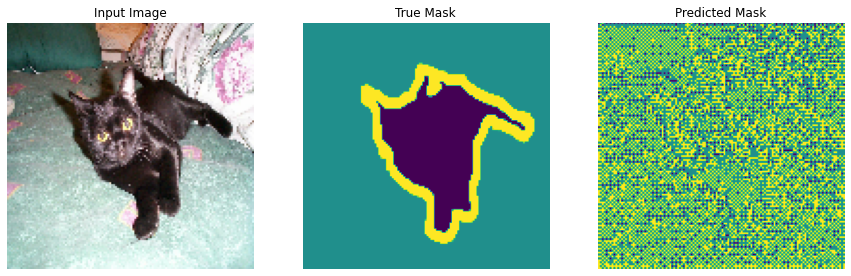

In [8]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  return tf.reshape(pred_mask,shape=(128,128,1))
  #pred_mask = pred_mask[..., tf.newaxis]
  #return pred_mask
  
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image[0])
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        idx = random.choice(range(64))
        display([sample_image[idx], sample_mask[idx],create_mask(model.predict(sample_image[idx][np.newaxis] ))])
  
show_predictions()

## CallBack to plot this predicted mask every epoch

In [11]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
57/57 [==============================] - 8s 134ms/step - loss: 0.3035 - accuracy: 0.8762 - val_loss: 0.3158 - val_accuracy: 0.8765


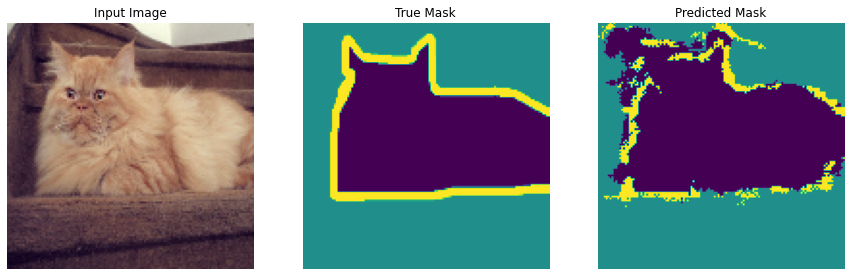


Sample Prediction after epoch 1

Epoch 2/20
57/57 [==============================] - 8s 135ms/step - loss: 0.2772 - accuracy: 0.8852 - val_loss: 0.3087 - val_accuracy: 0.8724


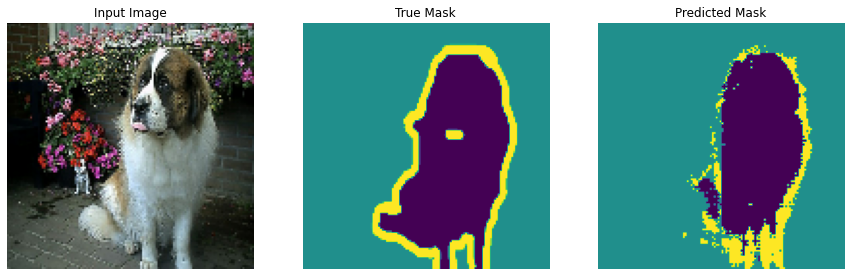


Sample Prediction after epoch 2

Epoch 3/20
57/57 [==============================] - 8s 134ms/step - loss: 0.2629 - accuracy: 0.8900 - val_loss: 0.2817 - val_accuracy: 0.8859


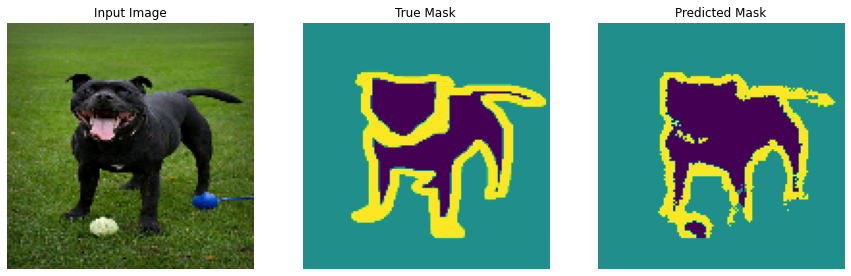


Sample Prediction after epoch 3

Epoch 4/20
57/57 [==============================] - 8s 134ms/step - loss: 0.2515 - accuracy: 0.8938 - val_loss: 0.2775 - val_accuracy: 0.8882


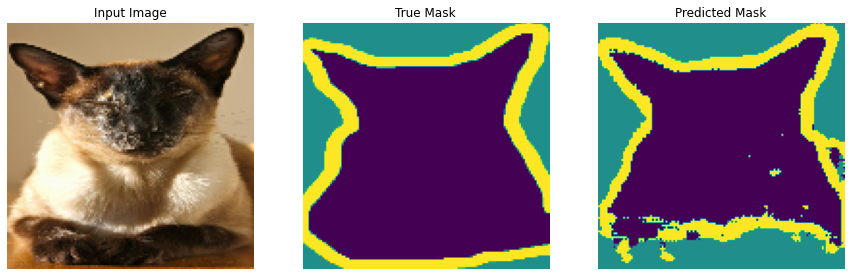


Sample Prediction after epoch 4

Epoch 5/20
57/57 [==============================] - 8s 136ms/step - loss: 0.2436 - accuracy: 0.8965 - val_loss: 0.2682 - val_accuracy: 0.8922


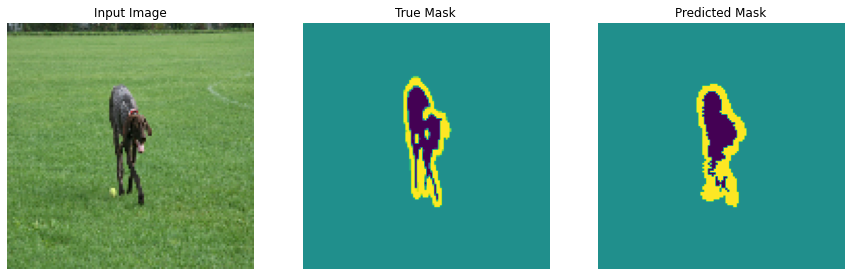


Sample Prediction after epoch 5

Epoch 6/20
57/57 [==============================] - 8s 136ms/step - loss: 0.2365 - accuracy: 0.8993 - val_loss: 0.2706 - val_accuracy: 0.8915


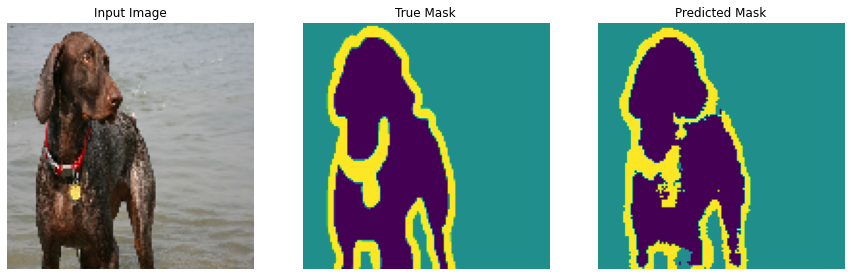


Sample Prediction after epoch 6

Epoch 7/20
57/57 [==============================] - 8s 139ms/step - loss: 0.2300 - accuracy: 0.9016 - val_loss: 0.2711 - val_accuracy: 0.8912


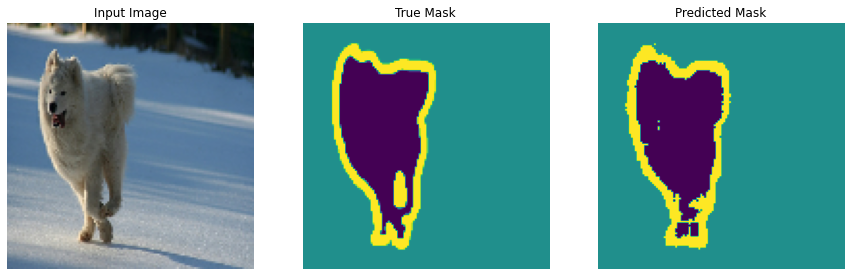


Sample Prediction after epoch 7

Epoch 8/20
57/57 [==============================] - 8s 138ms/step - loss: 0.2225 - accuracy: 0.9042 - val_loss: 0.2664 - val_accuracy: 0.8931


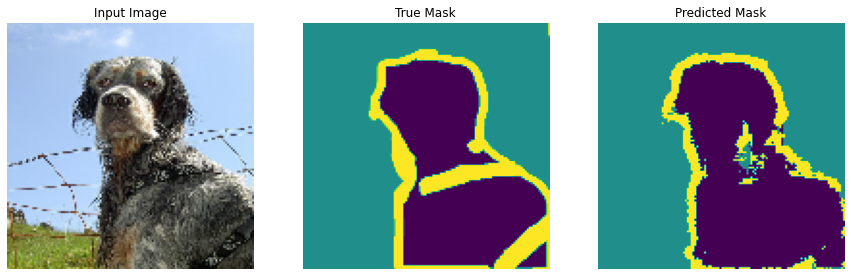


Sample Prediction after epoch 8

Epoch 9/20
57/57 [==============================] - 8s 139ms/step - loss: 0.2159 - accuracy: 0.9064 - val_loss: 0.2879 - val_accuracy: 0.8847


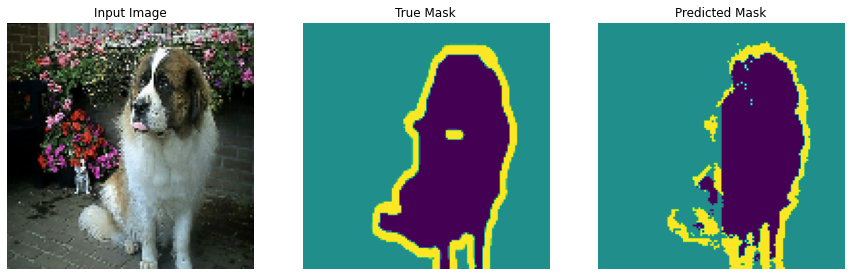


Sample Prediction after epoch 9

Epoch 10/20
57/57 [==============================] - 8s 140ms/step - loss: 0.2069 - accuracy: 0.9102 - val_loss: 0.2726 - val_accuracy: 0.8923


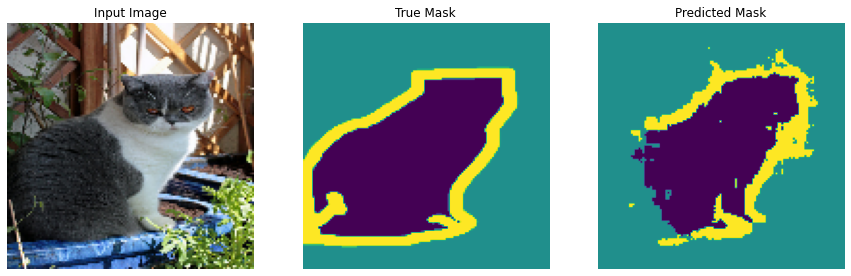


Sample Prediction after epoch 10

Epoch 11/20
57/57 [==============================] - 8s 140ms/step - loss: 0.1983 - accuracy: 0.9132 - val_loss: 0.2856 - val_accuracy: 0.8864


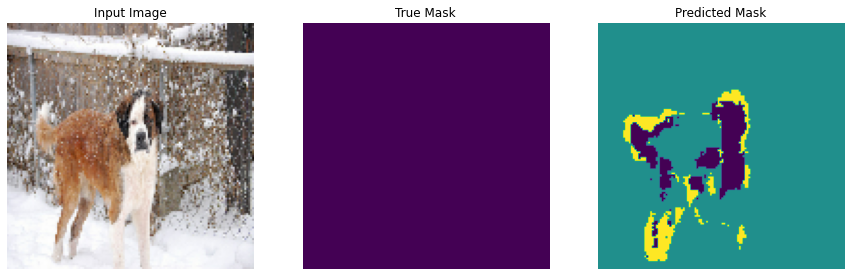


Sample Prediction after epoch 11

Epoch 12/20
57/57 [==============================] - 8s 141ms/step - loss: 0.1904 - accuracy: 0.9161 - val_loss: 0.2786 - val_accuracy: 0.8908


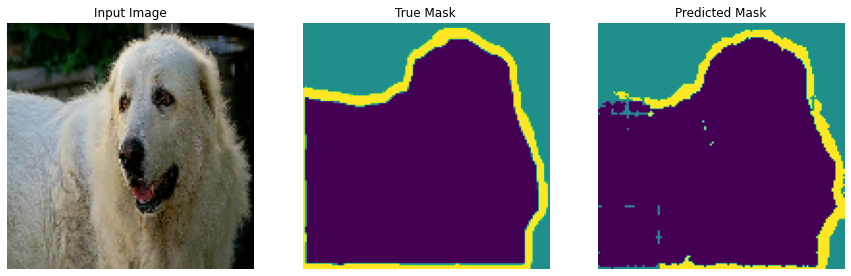


Sample Prediction after epoch 12

Epoch 13/20
57/57 [==============================] - 8s 143ms/step - loss: 0.1847 - accuracy: 0.9184 - val_loss: 0.2798 - val_accuracy: 0.8924


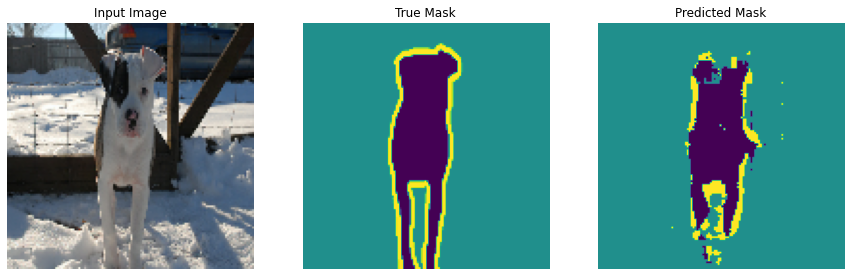


Sample Prediction after epoch 13

Epoch 14/20
57/57 [==============================] - 8s 144ms/step - loss: 0.1758 - accuracy: 0.9219 - val_loss: 0.2851 - val_accuracy: 0.8901


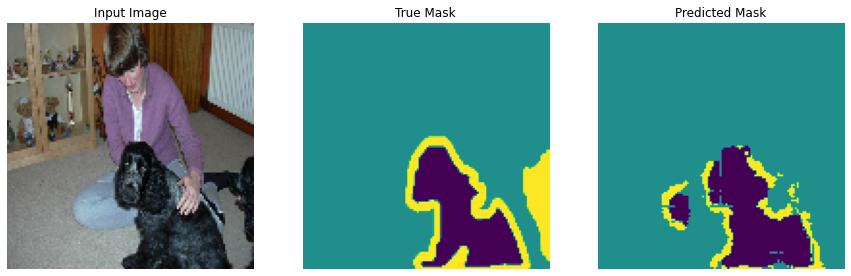


Sample Prediction after epoch 14

Epoch 15/20
57/57 [==============================] - 8s 145ms/step - loss: 0.1689 - accuracy: 0.9247 - val_loss: 0.2848 - val_accuracy: 0.8930


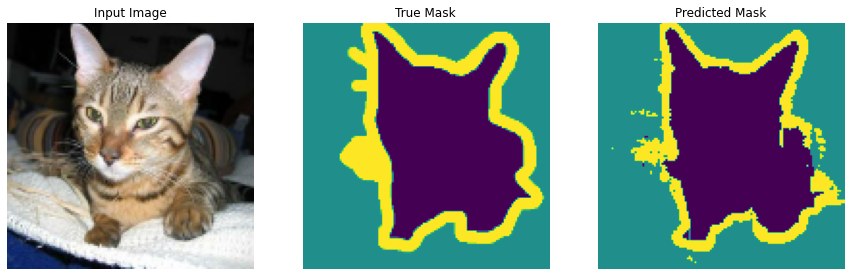


Sample Prediction after epoch 15

Epoch 16/20
57/57 [==============================] - 8s 146ms/step - loss: 0.1606 - accuracy: 0.9278 - val_loss: 0.2936 - val_accuracy: 0.8919


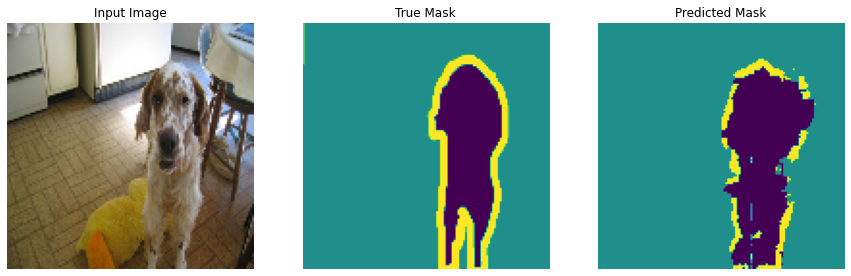


Sample Prediction after epoch 16

Epoch 17/20
57/57 [==============================] - 8s 146ms/step - loss: 0.1565 - accuracy: 0.9295 - val_loss: 0.2914 - val_accuracy: 0.8921


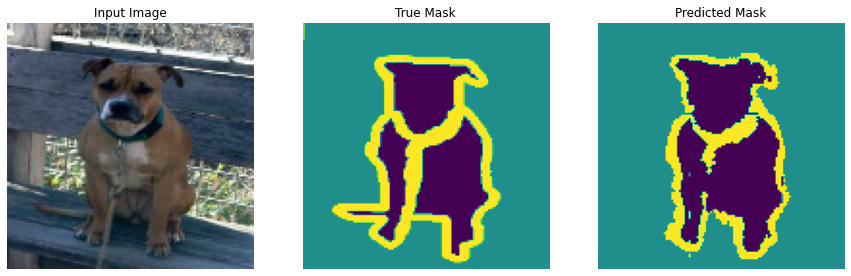


Sample Prediction after epoch 17

Epoch 18/20
57/57 [==============================] - 8s 146ms/step - loss: 0.1506 - accuracy: 0.9320 - val_loss: 0.3043 - val_accuracy: 0.8908


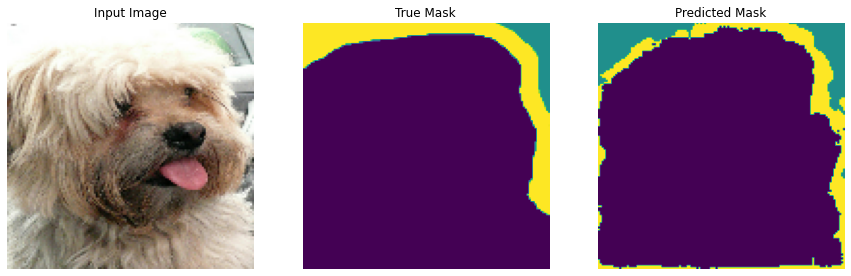


Sample Prediction after epoch 18

Epoch 19/20
57/57 [==============================] - 8s 144ms/step - loss: 0.1425 - accuracy: 0.9352 - val_loss: 0.3029 - val_accuracy: 0.8913


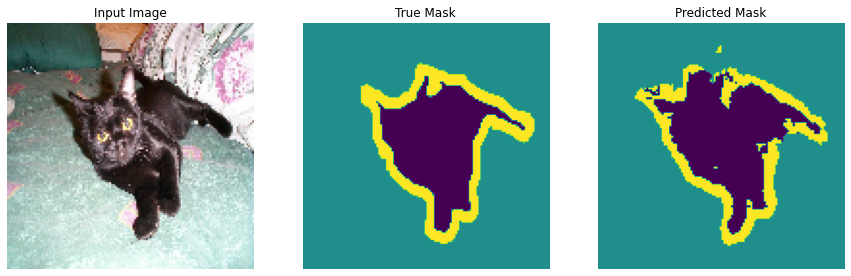


Sample Prediction after epoch 19

Epoch 20/20
57/57 [==============================] - 8s 143ms/step - loss: 0.1383 - accuracy: 0.9371 - val_loss: 0.3182 - val_accuracy: 0.8904


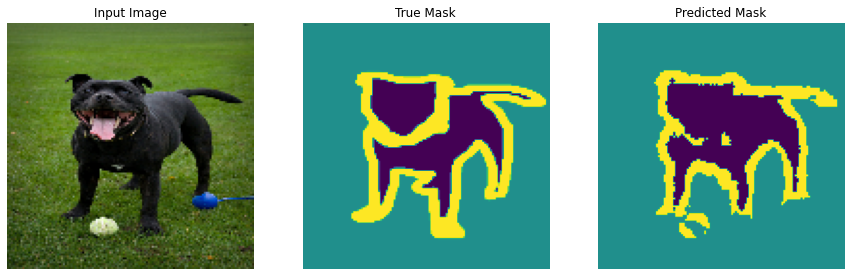


Sample Prediction after epoch 20



In [12]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//batch_size//VAL_SUBSPLITS

model_history = model.fit(
    train, 
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=VALIDATION_STEPS,
    validation_data=test,
    callbacks=[DisplayCallback()]
    )
